<a href="https://colab.research.google.com/github/sherna90/inteligencia_artificial/blob/master/7.-cnn_mnist_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Convolucionales

Este tutorial te guiará a través del proceso de creación, entrenamiento y validación de una red neuronal convolucional (CNN) usando JAX y Flax para clasificar imágenes del dataset MNIST.

1. Examine and understand the data
1. Build an input pipeline, in this case using Keras ImageDataGenerator
1. Compose the model
   * Load in the pretrained base model (and pretrained weights)
   * Stack the classification layers on top
1. Train the model
1. Evaluate model


In [ ]:
!pip install jax jaxlib flax optax matplotlib


In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax
import numpy as np
import matplotlib.pyplot as plt
#import tensorflow as tf
#from tensorflow.keras.datasets import mnist

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

### Arquitectura de la CNN

### Modelo

Usaremos Flax Linen para definir la CNN. Este ejemplo incluye dos capas convolucionales seguidas de una capa densa para la clasificación.



In [6]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
      x = nn.Conv(features=32, kernel_size=(3, 3))(x)
      x = nn.relu(x)
      x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
      x = nn.Conv(features=64, kernel_size=(3, 3))(x)
      x = nn.relu(x)
      x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
      x = x.reshape((x.shape[0], -1)) # Aplanar la salida para la capa densa
      x = nn.Dense(features=10)(x)
      return x

Cargar y preprocesar el dataset MNIST:

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalizar y añadir una dimensión para el canal
x_train = x_train.astype(jnp.float32) / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.astype(jnp.float32) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = jax.nn.one_hot(y_train, num_classes=10)
y_test = jax.nn.one_hot(y_test, num_classes=10)



11490434/11490434 [==============================] - 1s 0us/step


In [8]:
x_train.shape,y_train.shape

((60000, 28, 28, 1), (60000, 10))

In [9]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

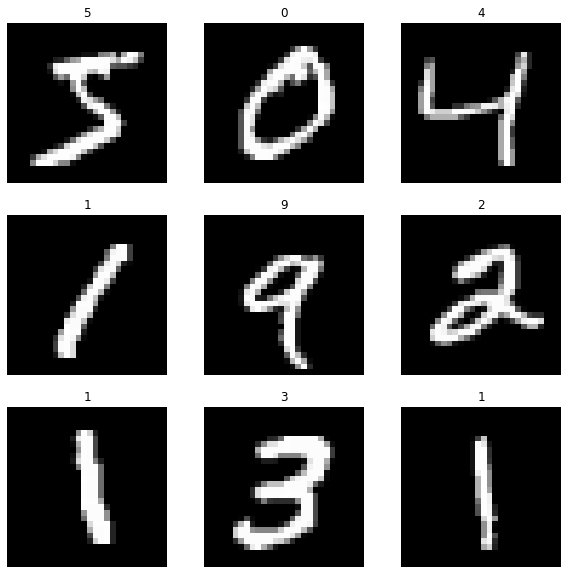

In [10]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(x_train[i],cmap='gray')
  plt.title(class_names[jnp.argmax(y_train[i])])
  plt.axis("off")

Inicializar el modelo y el estado de entrenamiento:

In [15]:
@jax.jit
def predict(params, inputs):
  return net.apply({"params": params}, inputs)


@jax.jit
def loss_fun(params, data):
  inputs, labels = data
  logits = predict(params, inputs)
  loss = optax.softmax_cross_entropy(logits=logits, labels=labels).mean()
  return loss


net = CNN()
optimizer = optax.adam(1e-3)
rng = jax.random.PRNGKey(0)
dummy_data = jnp.zeros((1, 28, 28, 1))
params = net.init({"params": rng}, dummy_data)["params"]

In [22]:
jax.tree_map(lambda p: jnp.shape(p),params)

{'Conv_0': {'bias': (32,), 'kernel': (3, 3, 1, 32)},
 'Conv_1': {'bias': (64,), 'kernel': (3, 3, 32, 64)},
 'Dense_0': {'bias': (10,), 'kernel': (3136, 10)}}

In [25]:
3*3*32*64/6+64

3136.0

 Definir la función y ciclo de entrenamiento usando mini-batches.

In [26]:
def train_step(params, optimizer, x_train, y_train,x_test,y_test,num_epochs=10,batch_size=64):
  """Computes loss and accuracy over the dataset `data_loader`."""
  opt_state = optimizer.init(params)
  train_accuracy = []
  train_loss = []
  test_accuracy = []
  test_loss = []
  for j in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
      batch_images = x_train[i:i+batch_size]
      batch_labels = y_train[i:i+batch_size]
      loss, grads = jax.value_and_grad(loss_fun)(params, (batch_images, batch_labels))
      updates, opt_state = optimizer.update(grads, opt_state)
      params = optax.apply_updates(params, updates)
      predictions = predict(params, batch_images)
      accuracy = jnp.mean(jnp.argmax(predictions, axis=-1) == jnp.argmax(batch_labels, axis=-1))
      train_accuracy.append(accuracy)
      train_loss.append(loss)
    if j % (num_epochs//10) == 0:
      test_predictions = predict(params, x_test)
      test_accuracy.append(jnp.mean(jnp.argmax(test_predictions, axis=-1) == jnp.argmax(y_test, axis=-1)))
      test_loss.append(loss_fun(params,(x_test,y_test)))
      print(f"Epoch {j}, Loss: {loss}, Accuracy: {accuracy}")
  return params,(train_loss,train_accuracy),(test_loss,test_accuracy)

In [27]:
updated_params,train_history,test_history=train_step(params, optimizer, x_train, y_train,x_test,y_test)

Epoch 0, Loss: 0.03320257365703583, Accuracy: 1.0
Epoch 1, Loss: 0.004114678129553795, Accuracy: 1.0
Epoch 2, Loss: 0.0027005355805158615, Accuracy: 1.0
Epoch 3, Loss: 0.0034238870721310377, Accuracy: 1.0
Epoch 4, Loss: 0.003192773787304759, Accuracy: 1.0
Epoch 5, Loss: 0.0035385394003242254, Accuracy: 1.0
Epoch 6, Loss: 0.00048785144463181496, Accuracy: 1.0
Epoch 7, Loss: 0.0003866527695208788, Accuracy: 1.0
Epoch 8, Loss: 0.00030919801793061197, Accuracy: 1.0
Epoch 9, Loss: 0.00010290610953234136, Accuracy: 1.0


In [28]:
jnp.argmax(y_train[-10:],axis=-1)

Array([9, 2, 9, 5, 1, 8, 3, 5, 6, 8], dtype=int32)

In [31]:
predictions = predict(updated_params, x_train[-10:])
jnp.argmax(predictions, axis=-1)

Array([9, 2, 9, 5, 1, 8, 3, 5, 6, 8], dtype=int32)

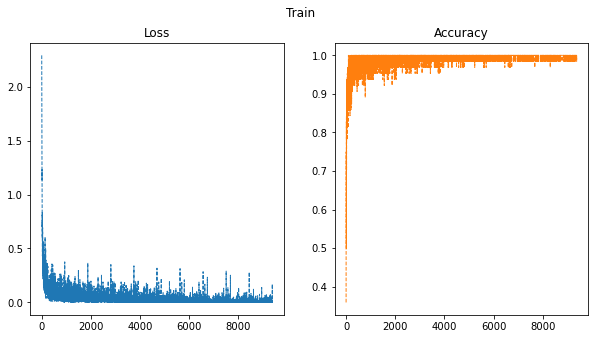

In [32]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True, sharey=False,figsize=(10,5))
fig.suptitle('Train')
ax1.plot(train_history[0],linewidth=1, linestyle='--')
ax1.set_title('Loss')
ax2.plot(train_history[1],'tab:orange',linewidth=1, linestyle='--')
ax2.set_title('Accuracy')
plt.show()

In [34]:
60000/64*10

9375.0

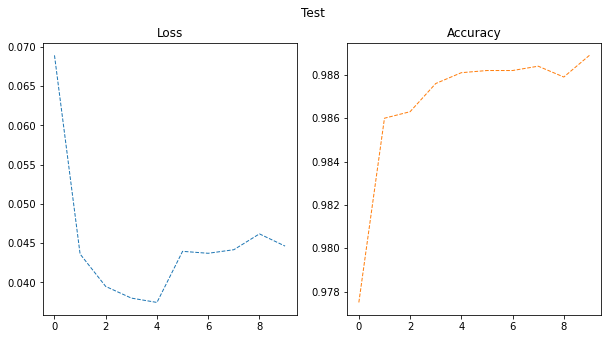

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True, sharey=False,figsize=(10,5))
fig.suptitle('Test')
ax1.plot(test_history[0],linewidth=1, linestyle='--')
ax1.set_title('Loss')
ax2.plot(test_history[1],'tab:orange',linewidth=1, linestyle='--')
ax2.set_title('Accuracy')
plt.show()

# Selección del Modelo

In [36]:
from typing import Any, Callable, Sequence,Tuple

class ExplicitCNN(nn.Module):
  features: Sequence[int]
  kernel_size: Tuple[int, int] = (3, 3)
  strides: Tuple[int, int] = (1, 1)
  padding: str = "SAME"
  activation: Callable[[Any], Any] = nn.relu
  pooling: Callable[[Any], Any] = nn.max_pool
  pool_size: Tuple[int, int] = (2, 2)
  batch_norm: bool = False

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
      if i != len(self.features):
        x = nn.Conv(features=feat, kernel_size=self.kernel_size,name=f'cnn_layer_{i}')(x)
        x = self.activation(x)
        x = self.pooling(x, window_shape=self.pool_size, strides=self.strides)
    x = x.reshape((x.shape[0], -1)) # Aplanar la salida para la capa densa
    x = nn.Dense(features=10,name=f'bottleneck')(x)
    return x

In [40]:
rng = jax.random.PRNGKey(0)

net = ExplicitCNN(features=[8,32],pooling=nn.avg_pool,activation=nn.tanh)
optimizer = optax.adam(1e-3)
dummy_data = jnp.zeros((1, 28, 28, 1))
params = net.init({"params": rng}, dummy_data)["params"]
opt_state = optimizer.init(params)

In [42]:
jax.tree_map(lambda p: jnp.shape(p),params)

{'bottleneck': {'bias': (10,), 'kernel': (21632, 10)},
 'cnn_layer_0': {'bias': (8,), 'kernel': (3, 3, 1, 8)},
 'cnn_layer_1': {'bias': (32,), 'kernel': (3, 3, 8, 32)}}

In [45]:
updated_params,train_history,test_history=train_step(params, optimizer, x_train, y_train,x_test,y_test,num_epochs=10,batch_size=256)

Epoch 0, Loss: 0.2757613956928253, Accuracy: 0.96875
Epoch 1, Loss: 0.18675939738750458, Accuracy: 0.9895833730697632
Epoch 2, Loss: 0.16034621000289917, Accuracy: 0.9895833730697632
Epoch 3, Loss: 0.1520346850156784, Accuracy: 0.9895833730697632
Epoch 4, Loss: 0.1440628170967102, Accuracy: 0.9895833730697632
Epoch 5, Loss: 0.1345575451850891, Accuracy: 0.9895833730697632
Epoch 6, Loss: 0.12658771872520447, Accuracy: 0.9895833730697632
Epoch 7, Loss: 0.11798541247844696, Accuracy: 0.9895833730697632
Epoch 8, Loss: 0.10954972356557846, Accuracy: 0.9895833730697632
Epoch 9, Loss: 0.10254234075546265, Accuracy: 0.9895833730697632


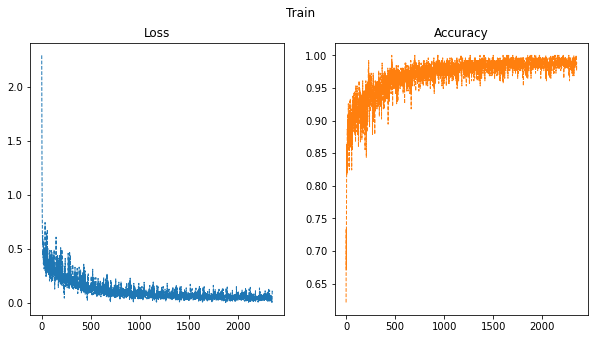

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True, sharey=False,figsize=(10,5))
fig.suptitle('Train')
ax1.plot(train_history[0],linewidth=1, linestyle='--')
ax1.set_title('Loss')
ax2.plot(train_history[1],'tab:orange',linewidth=1, linestyle='--')
ax2.set_title('Accuracy')
plt.show()

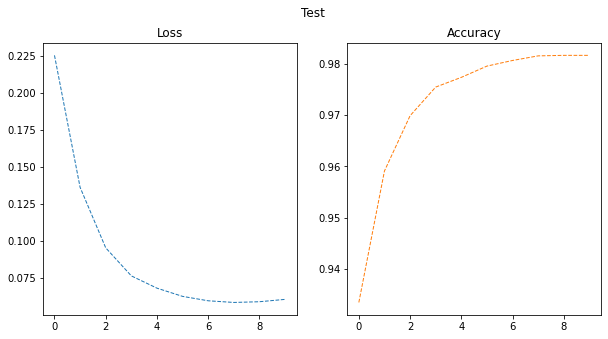

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True, sharey=False,figsize=(10,5))
fig.suptitle('Test')
ax1.plot(test_history[0],linewidth=1, linestyle='--')
ax1.set_title('Loss')
ax2.plot(test_history[1],'tab:orange',linewidth=1, linestyle='--')
ax2.set_title('Accuracy')
plt.show()

In [50]:
y_hat=predict(updated_params,x_test)
predictions=jnp.argmax(y_hat,axis=-1)
labels=jnp.argmax(y_test,axis=-1)


In [56]:
labels

Array([7, 2, 1, ..., 4, 5, 6], dtype=int32)

In [55]:
predictions

Array([7, 2, 1, ..., 4, 5, 6], dtype=int32)

In [58]:
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [60]:
from sklearn.metrics import confusion_matrix

confusion_matrix(labels,predictions)

array([[ 973,    1,    1,    1,    0,    1,    2,    0,    1,    0],
       [   1, 1129,    2,    1,    1,    0,    0,    0,    1,    0],
       [   4,    2, 1015,    0,    2,    0,    2,    3,    3,    1],
       [   2,    0,    4,  989,    1,    7,    0,    2,    3,    2],
       [   2,    0,    2,    0,  972,    0,    3,    0,    1,    2],
       [   2,    0,    0,    5,    0,  881,    2,    0,    2,    0],
       [   9,    3,    0,    0,    2,    6,  937,    0,    1,    0],
       [   2,    4,   13,    1,    2,    1,    0,  987,    4,   14],
       [   7,    0,    3,    1,    3,    2,    2,    2,  948,    6],
       [   2,    4,    0,    1,    6,    5,    1,    4,    0,  986]])

In [62]:
from sklearn.metrics import classification_report

print(classification_report(labels,predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

